In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [6]:
# MNIST dataset
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

train_all = datasets.MNIST('../data', train=True, download=True, transform=transform)
train_data, val_data = torch.utils.data.random_split(train_all, [50000, 10000])
test_data = datasets.MNIST('../data', train=False, transform=transform)

Epoch 1/10, Loss: 2.262241159253718, Validation Accuracy: 0.4674
Epoch 2/10, Loss: 0.6941344764112206, Validation Accuracy: 0.9042
Epoch 3/10, Loss: 0.22859272902921948, Validation Accuracy: 0.9466
Epoch 4/10, Loss: 0.15283074486486214, Validation Accuracy: 0.9589
Epoch 5/10, Loss: 0.11993379757055998, Validation Accuracy: 0.9643
Epoch 6/10, Loss: 0.1011524717728405, Validation Accuracy: 0.9664
Epoch 7/10, Loss: 0.08823109541178854, Validation Accuracy: 0.9712
Epoch 8/10, Loss: 0.07897574133823251, Validation Accuracy: 0.9732
Epoch 9/10, Loss: 0.07165178829444396, Validation Accuracy: 0.9731
Epoch 10/10, Loss: 0.06582594430967308, Validation Accuracy: 0.977
Test Accuracy: 0.9824


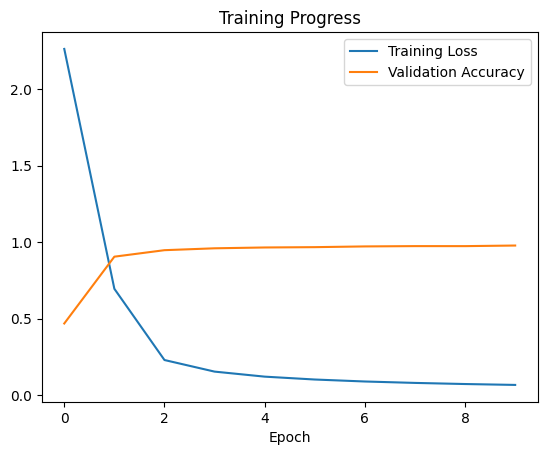

In [9]:
'''
Qeustion 1:
    Implement LeNet architecture, and train on all the 50K training samples with vanilla SGD.
    Attach learning curves and report test accuracy
'''
import matplotlib.pyplot as plt

# Set seed for reproducibility
torch.manual_seed(0)

# Define the LeNet architecture
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16*4*4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 16*4*4)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the network
lenet = LeNet()

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer (SGD)
optimizer = optim.SGD(lenet.parameters(), lr=0.01)

# MNIST dataset
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Prepare data loaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# Function to train and validate the model
def train_and_validate(model, train_loader, val_loader, optimizer, criterion, epochs):
    model.train()
    training_history = {'train_loss': [], 'val_accuracy': []}
    
    for epoch in range(epochs):
        total_loss = 0
        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        # Validation
        correct = 0
        total = 0
        with torch.no_grad():
            for data, target in val_loader:
                output = model(data)
                _, predicted = torch.max(output.data, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()
        
        val_accuracy = correct / total
        training_history['train_loss'].append(total_loss / len(train_loader))
        training_history['val_accuracy'].append(val_accuracy)
        print(f'Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(train_loader)}, Validation Accuracy: {val_accuracy}')
    
    return training_history

# Train the model
history = train_and_validate(lenet, train_loader, val_loader, optimizer, criterion, epochs=10)

# Test the model
lenet.eval()
correct = 0
total = 0
with torch.no_grad():
    for data, target in test_loader:
        output = lenet(data)
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

test_accuracy = correct / total
print(f'Test Accuracy: {test_accuracy}')

# Plot the learning curves
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Training Progress')
plt.xlabel('Epoch')
plt.legend()
plt.show()


Epoch 1/10, Loss: 0.08352566969490437, Validation Accuracy: 0.9791
Epoch 2/10, Loss: 0.05423970473960013, Validation Accuracy: 0.9793
Epoch 3/10, Loss: 0.04073130600819843, Validation Accuracy: 0.9794
Epoch 4/10, Loss: 0.03209313697388867, Validation Accuracy: 0.9864
Epoch 5/10, Loss: 0.026233508646035034, Validation Accuracy: 0.983
Epoch 6/10, Loss: 0.019385182253240495, Validation Accuracy: 0.9865
Epoch 7/10, Loss: 0.01718150594306257, Validation Accuracy: 0.9867
Epoch 8/10, Loss: 0.012682007738155388, Validation Accuracy: 0.9882
Epoch 9/10, Loss: 0.008565306662815362, Validation Accuracy: 0.9875
Epoch 10/10, Loss: 0.007298587362392029, Validation Accuracy: 0.99


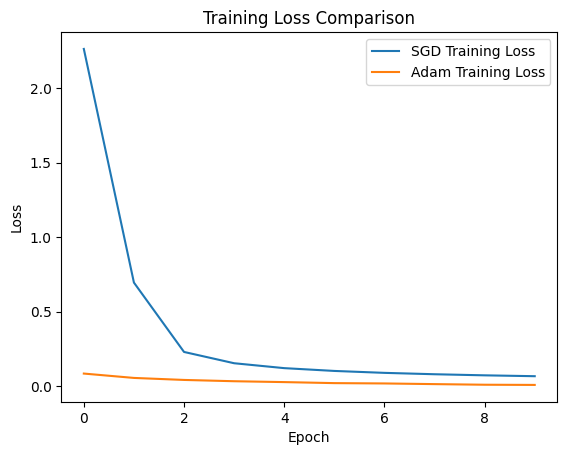

In [10]:
'''
Question 2:
    How can we make the training loss converge faster? Implement your idea and compare the new
    training curve against that in question 1.

Answer:
    - Use a more advanced optimization algorithm: Replace SGD with optimizers like Adam or RMSprop,
    which use adaptive learning rates and momentum.
'''
# Adjusted optimizer - using Adam
optimizer = optim.Adam(lenet.parameters(), lr=0.001)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

# Adjusted training function to include scheduler step
def train_and_validate_with_scheduler(model, train_loader, val_loader, optimizer, criterion, scheduler, epochs):
    model.train()
    training_history = {'train_loss': [], 'val_accuracy': []}
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        # Step through the scheduler
        scheduler.step()
        
        # Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data, target in val_loader:
                output = model(data)
                _, predicted = torch.max(output.data, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()
        
        val_accuracy = correct / total
        training_history['train_loss'].append(total_loss / len(train_loader))
        training_history['val_accuracy'].append(val_accuracy)
        print(f'Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(train_loader)}, Validation Accuracy: {val_accuracy}')
    
    return training_history

# Training the model with the new optimizer and scheduler
history_adam = train_and_validate_with_scheduler(lenet, train_loader, val_loader, optimizer, criterion, scheduler, epochs=10)

# Plot the learning curves for comparison
plt.plot(history['train_loss'], label='SGD Training Loss')
plt.plot(history_adam['train_loss'], label='Adam Training Loss')
plt.title('Training Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


Epoch 1/10, Loss: 0.8615707757936162, Validation Accuracy: 0.918
Epoch 2/10, Loss: 0.24470016011481832, Validation Accuracy: 0.949
Epoch 3/10, Loss: 0.1686678464364284, Validation Accuracy: 0.9552
Epoch 4/10, Loss: 0.1273876990482306, Validation Accuracy: 0.9682
Epoch 5/10, Loss: 0.10685116737179316, Validation Accuracy: 0.9735
Epoch 6/10, Loss: 0.0851632842651693, Validation Accuracy: 0.9755
Epoch 7/10, Loss: 0.07641411028731211, Validation Accuracy: 0.9769
Epoch 8/10, Loss: 0.06377924093086819, Validation Accuracy: 0.9754
Epoch 9/10, Loss: 0.059759097559389414, Validation Accuracy: 0.9798
Epoch 10/10, Loss: 0.04872731560586127, Validation Accuracy: 0.9787
Epoch 1/10, Loss: 0.08336549068389036, Validation Accuracy: 0.9793
Epoch 2/10, Loss: 0.0583576578676672, Validation Accuracy: 0.9852
Epoch 3/10, Loss: 0.04428397804674933, Validation Accuracy: 0.9832
Epoch 4/10, Loss: 0.03498240782710476, Validation Accuracy: 0.9859
Epoch 5/10, Loss: 0.028208372759563692, Validation Accuracy: 0.9881

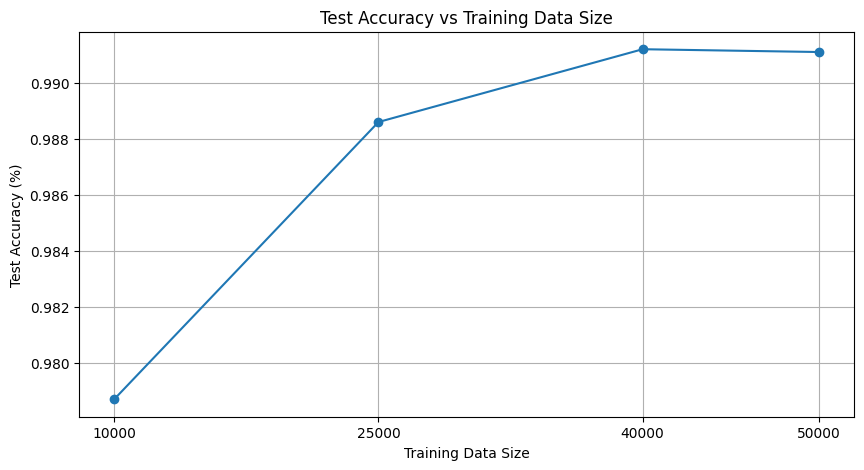

Test accuracies for different training sizes: [0.9787, 0.9886, 0.9912, 0.9911]


In [16]:
'''
Question 3:
    Train on 20%, 50%, 80% of the full 50K training samples, and report test accuracies. On a 2D
    coordinate (x-axis: training size; y-axis: test accuracy), plot the accuracies, along with the case of
    100% training samples (question 1). Discuss the result.

'''
# Define training sizes and store accuracies
training_sizes = [0.2, 0.5, 0.8, 1.0]  # Representing 20%, 50%, 80%, and 100% of the training data
accuracies = []

# Initialize the network
lenet = LeNet()

# Criterion
criterion = nn.CrossEntropyLoss()

# Train and evaluate for each specified training size
for size in training_sizes:
    # Calculate the number of samples for the subset
    subset_size = int(size * 50000)
    
    # Split the data into training and validation subsets
    train_subset, _ = torch.utils.data.random_split(train_all, [subset_size, len(train_all) - subset_size])
    
    # Create data loaders
    train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
    
    # Optimizer (Adam) and Scheduler
    optimizer = optim.Adam(lenet.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)
    
    # Train the model using the training subset and evaluate on the test set
    accuracy = train_and_validate_with_scheduler(lenet, train_loader, test_loader, optimizer, criterion, scheduler, epochs=10)
    accuracies.append(accuracy['val_accuracy'][-1])

# Plot accuracies against the training size
plt.figure(figsize=(10, 5))
plt.plot([size * 50000 for size in training_sizes], accuracies, marker='o')
plt.title('Test Accuracy vs Training Data Size')
plt.xlabel('Training Data Size')
plt.ylabel('Test Accuracy (%)')
plt.grid(True)
plt.xticks([size * 50000 for size in training_sizes])
plt.show()

# Output the accuracies for reference
print("Test accuracies for different training sizes:", accuracies)


In [ ]:
'''
Question 4:
    How can we improve the accuracies for cases with fewer training samples? Implement your idea
    and compare against what you get for question 3.
Answer:
    - Increasing training iteration
'''


# Define training sizes and store accuracies
training_size = 0.2  # Representing 20%, 50%, 80%, and 100% of the training data

# Initialize the network
lenet = LeNet()


# Criterion
criterion = nn.CrossEntropyLoss()

# Train and evaluate for each specified training size
# Calculate the number of samples for the subset
subset_size = int(training_size * 50000)
    
# Split the data into training and validation subsets
train_subset, _ = torch.utils.data.random_split(train_all, [subset_size, len(train_all) - subset_size])
    
# Create data loaders
train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
    
# Optimizer (Adam) and Scheduler
optimizer = optim.Adam(lenet.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)
    
        
# Train the model using the training subset and evaluate on the test set
accuracy = train_and_validate_with_scheduler(lenet, 
                                             train_loader, 
                                             test_loader, 
                                             optimizer,
                                             criterion, 
                                             scheduler, 
                                             epochs=20)
inc_accuracies = accuracy['val_accuracy'][-1]

# Data preparation
categories = ['Original', 'Increased Iterations']
accuracies = [accuracies[0], inc_accuracies]

# Bar positions
x = range(len(categories))

fig, ax = plt.subplots()
# Space between bars
bar_width = 0.4
offset = 0.1

rects1 = ax.bar(x[0], accuracies[0], bar_width, label=categories[0], color='skyblue')
rects2 = ax.bar(x[0] + bar_width + offset, accuracies[1], bar_width, label=categories[1], color='orange')

# Adding text for labels, title, and custom x-axis tick labels, etc.
ax.set_ylabel('Test Accuracy (%)')
ax.set_title('Test Accuracy by Training Size and Method')
ax.set_xticks([i + bar_width / 2 for i in x])
ax.legend()

# Narrow the y-axis range to magnify the difference
ax.set_ylim([0.9785, 0.9810])

# Function to add a label above each bar
def autolabel(rects):
    """Attach a text label above each bar displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()


Epoch 1/20, Loss: 0.8471982892911145, Validation Accuracy: 0.9242
Epoch 2/20, Loss: 0.19877341795404246, Validation Accuracy: 0.9522
Epoch 3/20, Loss: 0.13621242300482692, Validation Accuracy: 0.9614
Epoch 4/20, Loss: 0.10766857177920781, Validation Accuracy: 0.97
Epoch 5/20, Loss: 0.0905456470479821, Validation Accuracy: 0.9738
Epoch 6/20, Loss: 0.07196890083467884, Validation Accuracy: 0.9724
Epoch 7/20, Loss: 0.06287798736019025, Validation Accuracy: 0.9773
Epoch 8/20, Loss: 0.05528331271396463, Validation Accuracy: 0.9743
Epoch 9/20, Loss: 0.04735447820216702, Validation Accuracy: 0.9781
Epoch 10/20, Loss: 0.04332656442976681, Validation Accuracy: 0.978
Epoch 11/20, Loss: 0.03722084014807015, Validation Accuracy: 0.9799
Epoch 12/20, Loss: 0.03359064374157601, Validation Accuracy: 0.9799
Epoch 13/20, Loss: 0.028893327752757034, Validation Accuracy: 0.9789
Epoch 14/20, Loss: 0.027306704660343708, Validation Accuracy: 0.9798
Epoch 15/20, Loss: 0.02430276854992933, Validation Accuracy:

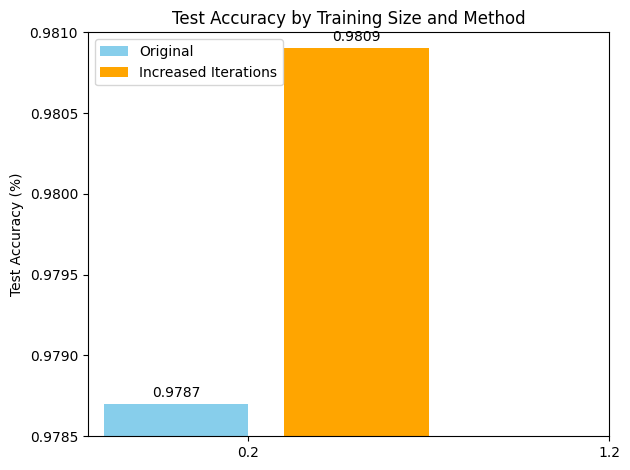

In [41]:
import matplotlib.pyplot as plt

# Example accuracies
original_accuracy = 0.9787  # Original test accuracy for 20% training data size
increased_accuracy = 0.9809  # Test accuracy with increased training iterations for 20% data size


